In [2]:
import pandas as pd
import numpy as np
#import gensim
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

import tensorflow
import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

%matplotlib inline

/Users/BharathiSrinivasan/anaconda2/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#Input data
train_orders = pd.read_csv("/Users/BharathiSrinivasan/Documents/HU-MEMS-Sem3/Info_Systems/repo/InstaCart/input/order_products__train.csv")
prior_orders = pd.read_csv("/Users/BharathiSrinivasan/Documents/HU-MEMS-Sem3/Info_Systems/repo/InstaCart/input/order_products__prior.csv")
products = pd.read_csv("/Users/BharathiSrinivasan/Documents/HU-MEMS-Sem3/Info_Systems/repo/InstaCart/input/products.csv").set_index('product_id')

In [4]:
print(train_orders.shape)
print(prior_orders.shape)

(1384617, 4)
(32434489, 4)


In [5]:
print(len(np.unique(train_orders.order_id)), "unique orders in train")
print(len(np.unique(prior_orders.order_id)), "unique orders in prior")
print(len(np.unique(train_orders.product_id)), "unique products in train")
print(len(np.unique(prior_orders.product_id)), "unique products in prior")

131209 unique orders in train
3214874 unique orders in prior
39123 unique products in train
49677 unique products in prior


In [6]:
%%time
train_orders["product_id"] = train_orders["product_id"].astype(str)
prior_orders["product_id"] = prior_orders["product_id"].astype(str)

CPU times: user 32.3 s, sys: 3.19 s, total: 35.5 s
Wall time: 35.7 s


In [7]:
%%time
train_products = train_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())
prior_products = prior_orders.groupby("order_id").apply(lambda order: order['product_id'].tolist())

CPU times: user 3min 48s, sys: 5.83 s, total: 3min 54s
Wall time: 3min 55s


In [8]:
train_products.head()

order_id
1     [49302, 11109, 10246, 49683, 43633, 13176, 472...
36    [39612, 19660, 49235, 43086, 46620, 34497, 486...
38    [11913, 18159, 4461, 21616, 23622, 32433, 2884...
96    [20574, 30391, 40706, 25610, 27966, 24489, 39275]
98    [8859, 19731, 43654, 13176, 4357, 37664, 34065...
dtype: object

In [9]:
prior_products.head()

order_id
2    [33120, 28985, 9327, 45918, 30035, 17794, 4014...
3    [33754, 24838, 17704, 21903, 17668, 46667, 174...
4    [46842, 26434, 39758, 27761, 10054, 21351, 225...
5    [13176, 15005, 47329, 27966, 23909, 48370, 132...
6                                [40462, 15873, 41897]
dtype: object

In [10]:
%%time
sentences = prior_products.append(train_products)
longest = np.max(sentences.apply(len))
sentences = sentences.values

CPU times: user 954 ms, sys: 142 ms, total: 1.1 s
Wall time: 1.1 s


In [12]:
type(sentences)
sentences.shape

(3346083,)

In [13]:
sentences[np.r_[0:2, -2:0]]

array([list(['33120', '28985', '9327', '45918', '30035', '17794', '40141', '1819', '43668']),
       list(['33754', '24838', '17704', '21903', '17668', '46667', '17461', '32665']),
       list(['49235', '13565', '14233', '35548']),
       list(['35951', '16953', '4724'])], dtype=object)

Wall time: 4min 45s


In [32]:
%%time
vocab = list(model.wv.vocab.keys())

Wall time: 13 ms


In [43]:
#vocab[0:10]

['33120',
 '28985',
 '9327',
 '45918',
 '30035',
 '17794',
 '40141',
 '1819',
 '43668',
 '33754']

In [44]:
#display(model.most_similar('33120'))

[('49075', 0.7379200458526611),
 ('5646', 0.7055116891860962),
 ('28289', 0.6989336609840393),
 ('11090', 0.696395754814148),
 ('17878', 0.6666847467422485),
 ('10017', 0.6618810892105103),
 ('4799', 0.6419677734375),
 ('41328', 0.6361633539199829),
 ('33401', 0.6323817372322083),
 ('21543', 0.627264142036438)]

In [38]:
%%time
def tfidf_word2vec_transform(model, embed_dim, inv_dic_tfidf, score_tfidf):
    tfidf_word2vec = np.zeros((score_tfidf.shape[0], embed_dim))
    for i in range(score_tfidf.shape[0]):
        doc_word2vec = np.zeros(embed_dim)
        for j in range(score_tfidf.shape[1]):
            doc_word2vec += score_tfidf[i, j] * model[inv_dic_tfidf[j]]
        tfidf_word2vec[i, :] = doc_word2vec
    return tfidf_word2vec

X_train_w2v = tfidf_word2vec_transform(model, 64, inverse_dictionary, X_train)
X_test_w2v = tfidf_word2vec_transform(model, 64, inverse_dictionary, X_test)

NameError: name 'inverse_dictionary' is not defined

In [12]:
%%time
pca = PCA(n_components=2)
pca.fit(model.wv.syn0)

Wall time: 329 ms


In [13]:
%%time
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    """From Tensorflow's tutorial."""
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
#     plt.savefig(filename)
    plt.show()

Wall time: 0 ns


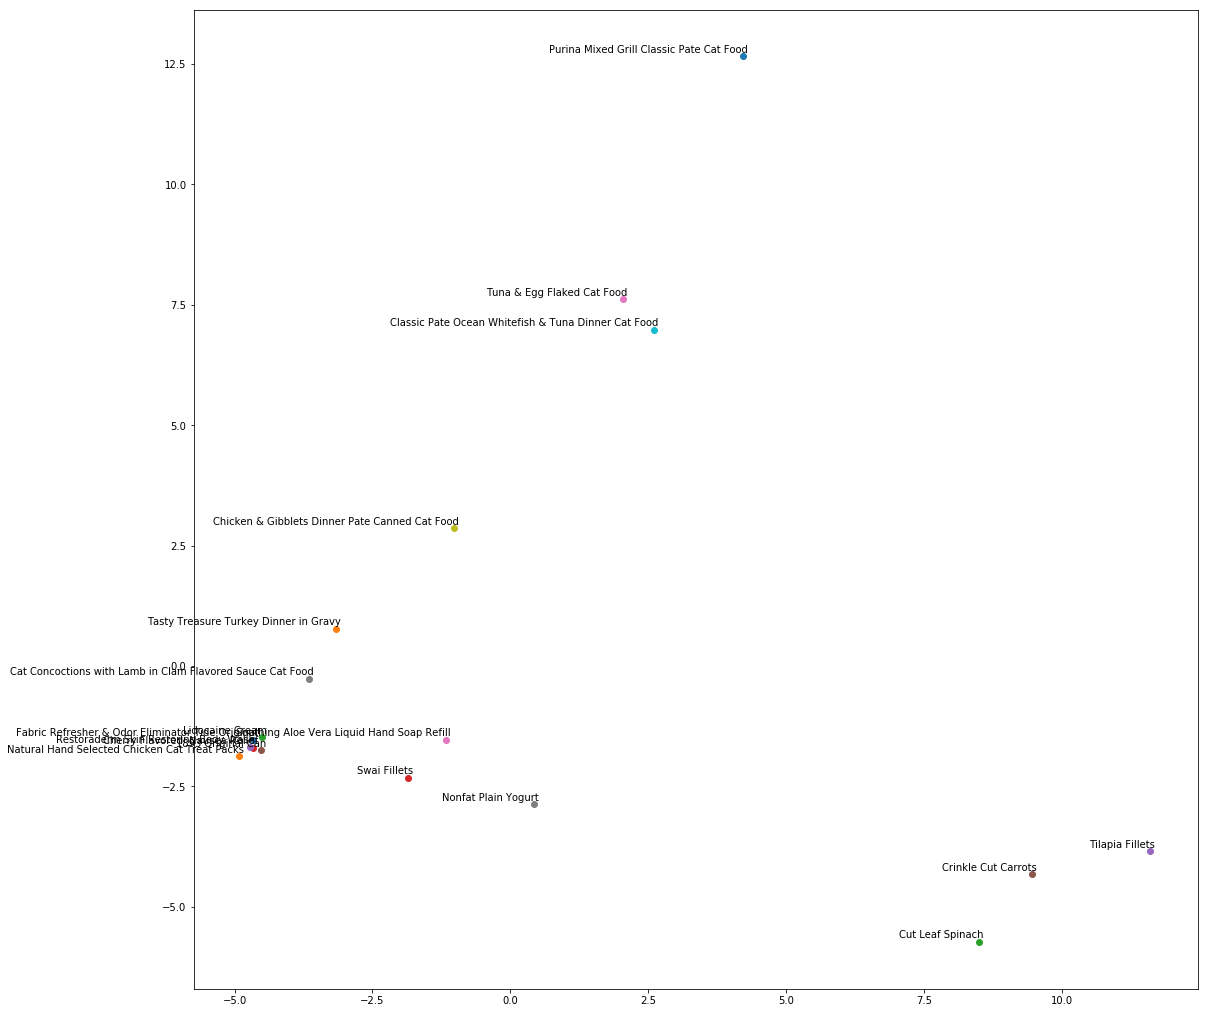

In [14]:
%%time
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=3):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name'])
embeds = np.array(embeds)
embeds = pca.fit_transform(embeds)
plot_with_labels(embeds, labels)

In [15]:
%%time
model.save("product2vec.model")